In [1]:
import os
import numpy as np
import pandas as pd
from functools import reduce
from itertools import combinations

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 12})
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

/data5/deepro/miniconda3/envs/starrseq/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def read_and_filter_df(filename, libraries):
    df = pd.read_csv(filename)
    df = df.dropna()
    # proportional query
    query = " & ".join([
        f"((`{lib}_log2FoldChange_act`<0) & (`{lib}_log2FoldChange_exp`<0) | (`{lib}_log2FoldChange_act`>0) & (`{lib}_log2FoldChange_exp`>0))" for lib in libraries])
    df = df.query(query)
    return df

In [3]:
abc_file = "/data5/deepro/starrseq/papers/results/6_link_da_enhancers_to_de_genes/data/da_de_peaks/abc_da_de_table_peaks.csv"
nearest_file = "/data5/deepro/starrseq/papers/results/6_link_da_enhancers_to_de_genes/data/da_de_peaks/nearest_da_de_table_peaks.csv"
lib_names = ["ATF2", "CTCF", "FOXA1", "LEF1", "SCRT1", "TCF7L2"]

In [5]:
combos = list(combinations(lib_names,2))
discordant_counts = []

for lib_combo in combos:
    abc_df = read_and_filter_df(abc_file, lib_combo)
    nearest_df = read_and_filter_df(nearest_file, lib_combo)
    df = pd.concat((abc_df, nearest_df)).drop_duplicates(subset=["chrom_coord", "gene_name"])
    df = df.loc[((df["CC_peak"]==1|(df[f"{lib_combo[0]}_peak"]==1)|(df[f"{lib_combo[1]}_peak"]==1)))]
    df["eg_pairs"] = df.chrom_coord + "::" + df.gene_name
    df = df.set_index("eg_pairs")
    query = f"(`{lib_combo[0]}_log2FoldChange_act`>0) & (`{lib_combo[1]}_log2FoldChange_act`<0) | (`{lib_combo[0]}_log2FoldChange_act`<0) & (`{lib_combo[1]}_log2FoldChange_act`>0)"
    df = df.query(query)
    df = df.loc[:, [c for c in df.columns if c.startswith(lib_combo)]]
    discordant_counts.append(len(df))

In [6]:
count_matrix = np.zeros((len(lib_names), len(lib_names)))

In [7]:
combos_count_dict = dict(zip(combos, discordant_counts))

In [8]:
for i,li in enumerate(lib_names):
    for j,lj in enumerate(lib_names):
        if i!=j:
            combo = tuple(sorted([li, lj]))
            combo_count = combos_count_dict[combo]
            count_matrix[i,j] = combo_count
        else:
            count_matrix[i,j] = np.nan
            
    

In [9]:
plot_df = pd.DataFrame(count_matrix, index=lib_names, columns=lib_names)

<AxesSubplot:>

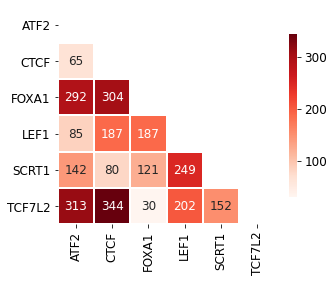

In [10]:
fig, ax = plt.subplots(figsize=(5,4))
matrix = np.triu(plot_df)
sns.heatmap(plot_df, annot=True, square=True, fmt="g", cmap="Reds", cbar_kws={"shrink":0.75}, linewidth=1.5, mask=matrix)

In [11]:
matrix

array([[ nan,  65., 292.,  85., 142., 313.],
       [  0.,  nan, 304., 187.,  80., 344.],
       [  0.,   0.,  nan, 187., 121.,  30.],
       [  0.,   0.,   0.,  nan, 249., 202.],
       [  0.,   0.,   0.,   0.,  nan, 152.],
       [  0.,   0.,   0.,   0.,   0.,  nan]])